In [54]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import combinations_with_replacement
import math
import torch

In [79]:
# Number of samples
n_samples = 1000
n_features = 10
output_size = 3
hidden_neurons_l1 = 40
hidden_neurons_l2 =25

In [3]:
#data generation

np.random.seed(52)

# Features
age = np.random.randint(10, 90, n_samples)
temp = np.random.normal(98.6, 1.5, n_samples)  # normal human temp
hr = np.random.randint(60, 140, n_samples)  # heart rate
bp_sys = np.random.randint(90, 180, n_samples)  # systolic BP
bp_dia = np.random.randint(60, 120, n_samples)  # diastolic BP
resp_rate = np.random.randint(12, 30, n_samples)  # breaths per min
chest_pain = np.random.randint(0, 2, n_samples)
bleeding = np.random.randint(0, 2, n_samples)
fever = (temp > 100.4).astype(int)
vomiting = np.random.randint(0, 2, n_samples)

# Label logic (basic rules for triage)
urgency = []
for i in range(n_samples):
    score = 0
    if hr[i] > 120: score += 1
    if temp[i] > 101: score += 1
    if chest_pain[i] == 1: score += 1
    if bleeding[i] == 1: score += 1
    if bp_sys[i] > 160 or bp_sys[i] < 100: score += 1
    if resp_rate[i] > 24 or resp_rate[i] < 14: score += 1
    if score >= 4:
        urgency.append(2)  # High
    elif score >= 2:
        urgency.append(1)  # Medium
    else:
        urgency.append(0)  # Low

# Combine into DataFrame
data = pd.DataFrame({
    'age': age,
    'temp': temp,
    'hr': hr,
    'bp_sys': bp_sys,
    'bp_dia': bp_dia,
    'resp_rate': resp_rate,
    'chest_pain': chest_pain,
    'bleeding': bleeding,
    'fever': fever,
    'vomiting': vomiting,
    'urgency_level': urgency
})

data.to_csv("triage_dataset.csv", index=False)
print("Dataset generated and saved as triage_dataset.csv")

Dataset generated and saved as triage_dataset.csv


In [56]:
#data reading and cleaning

df = pd.read_csv("triage_dataset.csv")

X = df.drop("urgency_level",axis=1).values
Y = df["urgency_level"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)

scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train))
X_test_scaled = torch.tensor(scaler.transform(X_test))

#degree=2

def one_hot_encode(labels,states=3):
    return np.eye(states)[labels]

#FINAL OUTPUT
print("x ",X.shape)
print("x_train ",X_train.shape)
print("x_test ",X_test.shape)

x  (1000, 10)
x_train  (800, 10)
x_test  (200, 10)


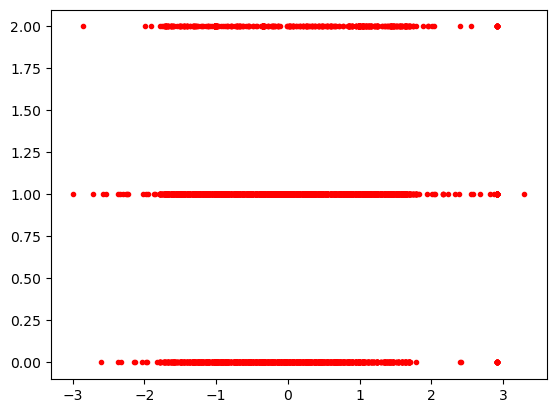

In [57]:
#visulaizing data
plt.plot(X_train_scaled,Y_train,'r.')
plt.show()

In [58]:
#predictions

def predictor(X):
    return torch.softmax(X@theta,dim=1)

In [71]:
def cross_entropy(y,y_pred,lamda):
    return (torch.mean(-torch.log(y_pred[range(len(y)),y])) + (lamda*(torch.mean(theta**2))) )

In [72]:
def forward_pass(x_train_scaled,t1,b1,t2,b2,t3,b3):
    a = x_train_scaled @ t1 + b1
    b = torch.tanh(a)
    c = b @ t2 +  b2
    d = torch.relu(c)
    e = d @ t3 + b3
    return torch.softmax(e,dim=1)

In [80]:
#loss function for training dataset (adding l2 regulariztaion penality in loss)

def loss_calc(y,y_pred,lamda,t1,t2,t3):
    return ((torch.mean(-torch.log(y_pred[range(len(y)),y]))) + lamda*(torch.mean(t1**2)+torch.mean(t2**2)+torch.mean(t3**2)))

In [81]:
#loss function for testing dataset

def test_loss_calc(y,y_pred):
    return ((torch.mean(-torch.log(y_pred[range(len(y)),y]))) )

In [91]:
#randomly initializing hyper-parameters

np.random.seed(42)
n = 20000
lamda = torch.linspace(1.0, 3.0, steps=40)  # [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
step_size = 0.7
train_loss_list=[]
test_loss_list=[]

In [92]:
#scaling data (to be all data on one same scale)

X_train_scaled = X_train_scaled.float()
X_test_scaled = X_test_scaled.float()

In [ ]:
#main loop for 

for j in range(40):
    theta1 = torch.randn(n_features,hidden_neurons_l1,requires_grad=True)
    theta2 = torch.randn(hidden_neurons_l1,hidden_neurons_l2,requires_grad=True)
    theta3 = torch.randn(hidden_neurons_l2,hidden_neurons_l3,requires_grad=True)
    bias1 = torch.randn(hidden_neurons_l1,requires_grad=True)
    bias2 = torch.randn(hidden_neurons_l2,requires_grad=True)
    bias3 = torch.randn(hidden_neurons_l3,requires_grad=True)
    for i in range(n+1):
        y_pred = forward_pass(X_train_scaled,theta1,bias1,theta2,bias2,theta3,bias3)
        y_pred = torch.clamp(y_pred, 1e-8, 1)
        loss = loss_calc(Y_train,y_pred,lamda[j],theta1,theta2,theta3)
        #if (i%100==0):
            #print(loss.item())
        #train_loss_list.append(loss.item())
        loss.backward()

        with torch.no_grad():
            theta1 -= step_size*theta1.grad
            theta2 -= step_size*theta2.grad
            theta3 -= step_size*theta3.grad
            bias1 -= step_size*bias1.grad
            bias2 -= step_size*bias2.grad
            bias3 -= step_size*bias3.grad

        theta1.grad.zero_()
        theta2.grad.zero_()
        theta3.grad.zero_()
        bias1.grad.zero_()
        bias2.grad.zero_()
        bias3.grad.zero_()

    train_loss_list.append(loss.item())
    y_test_pred = forward_pass(X_test_scaled,theta1,bias1,theta2,bias2,theta3,bias3)
    test_loss = loss_calc(Y_test,y_test_pred,lamda[j],theta1,theta2,theta3)
    test_loss_list.append(test_loss.item())
    print(j,"   lamda: ",lamda[j],"         Train loss:",loss.item(),"         Test loss:",test_loss.item())
    print(j,"Train Accuracy:", accuracy(Y_train, forward_pass(X_train_scaled.float(),theta1,bias1,theta2,bias2,theta3,bias3)))
    print(j,"Test Accuracy:", accuracy(Y_test, forward_pass(X_test_scaled.float(),theta1,bias1,theta2,bias2,theta3,bias3)))
    print()

0    lamda:  tensor(1.)          Train loss: 0.19998101890087128          Test loss: 0.48859935998916626
0 Train Accuracy: 0.9987499713897705
0 Test Accuracy: 0.8550000190734863



In [76]:
#finding number of epoch (on which test_loss-> minimum & test_accuracy-> minimum)

t_n = 100000
t_theta1 = torch.randn(n_features,hidden_neurons_l1,requires_grad=True)
t_theta2 = torch.randn(hidden_neurons_l1,hidden_neurons_l2,requires_grad=True)
t_theta3 = torch.randn(hidden_neurons_l2,output_size,requires_grad=True)
t_bias1 = torch.randn(hidden_neurons_l1,requires_grad=True)
t_bias2 = torch.randn(hidden_neurons_l2,requires_grad=True)
t_bias3 = torch.randn(output_size,requires_grad=True)
t_lamda =1.8462
loss_list =[]
final_train_loss=0.0
final_test_loss=0.0

In [77]:
#tunnung to find exact no of epoch

for i in range(t_n+1):
    y_pred = forward_pass(X_train_scaled,t_theta1,t_bias1,t_theta2,t_bias2,t_theta3,t_bias3)
    loss = loss_calc(Y_train,y_pred,t_lamda)
    if (i%10000==0):
        train_loss_list.append(loss.item())
        y_test_pred = forward_pass(X_train_scaled,t_theta1,t_bias1,t_theta2,t_bias2,t_theta3,t_bias3)
        y_test_pred = torch.clamp(y_pred, 1e-8, 1)
        final_test_loss = test_loss_calc(Y_test,y_test_pred)
        print(i,"   lamda: ",t_lamda,"         Train loss:",loss.item(),"         Test loss:",final_test_loss.item())
        print(i,"Test Accuracy:", accuracy(Y_test, forward_pass(X_test_scaled,t_theta1,t_bias1,t_theta2,t_bias2,t_theta3,t_bias3)))
        print()
    loss_list.append(loss.item())
    loss.backward()

    with torch.no_grad():
        t_theta1 -= step_size*theta1.grad
        t_theta2 -= step_size*theta2.grad
        t_theta3 -= step_size*theta3.grad
        t_bias1 -= step_size*bias1.grad
        t_bias2 -= step_size*bias2.grad
        t_bias3 -= step_size*bias3.grad

    t_theta1.grad.zero_()
    t_theta2.grad.zero_()
    t_theta3.grad.zero_()
    t_bias1.grad.zero_()
    t_bias2.grad.zero_()
    t_bias3.grad.zero_()
final_train_loss=loss.item()


0    lamda:  1.3846          Train loss: 13.539505958557129          Test loss: 7.45213508605957
0 Test Accuracy: 0.41499999165534973

10000    lamda:  1.3846          Train loss: inf          Test loss: 11.413674354553223
10000 Test Accuracy: 0.2750000059604645

20000    lamda:  1.3846          Train loss: inf          Test loss: 11.425314903259277
20000 Test Accuracy: 0.2849999964237213

30000    lamda:  1.3846          Train loss: inf          Test loss: 11.417906761169434
30000 Test Accuracy: 0.2849999964237213

40000    lamda:  1.3846          Train loss: inf          Test loss: 11.48057746887207
40000 Test Accuracy: 0.2849999964237213

50000    lamda:  1.3846          Train loss: inf          Test loss: 11.468620300292969
50000 Test Accuracy: 0.2849999964237213

60000    lamda:  1.3846          Train loss: inf          Test loss: 11.454367637634277
60000 Test Accuracy: 0.2849999964237213

70000    lamda:  1.3846          Train loss: inf          Test loss: 11.438514709472656
7000

In [33]:
#Final testing

train_loss_list.append(loss.item())
y_test_pred = forward_pass(X_test_scaled,t_theta1,t_bias1,theta2,bias2)
final_test_loss = test_loss_calc(Y_test,y_test_pred)
print(j,"   lamda: ",t_lamda,"         Train loss:",final_train_loss,"         Test loss:",final_test_loss.item())

13    lamda:  0.6923          Train loss: 0.0251957755535841          Test loss: 1.191048264503479


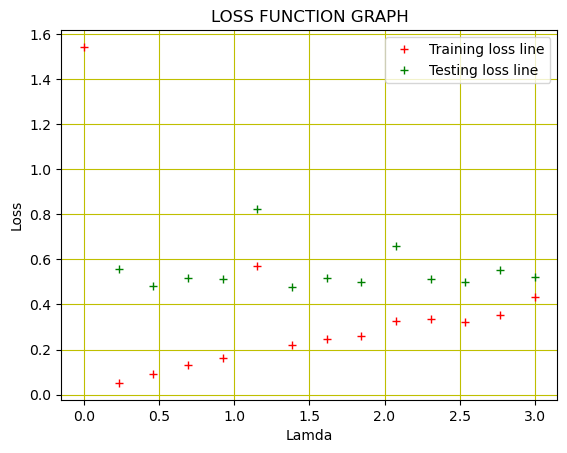

In [78]:
#plotting lamda vs test & traing loss to find the "SWEET SPOT"

plt.plot(lamda,train_loss_list,'r+',label='Training loss line')
plt.plot(lamda,test_loss_list,'g+',label='Testing loss line')
plt.title('Loss Function Graph')
plt.legend(loc='best')
plt.grid(True,color='y')
plt.xlabel('Lamda')
#plt.xlim(0,5)
#plt.ylim(-10000000,10000000)
plt.ylabel('Loss')
plt.title('LOSS FUNCTION GRAPH')
plt.show()

In [23]:
#ACCURACIES
def accuracy(y_true, y_pred):
    pred_labels = torch.argmax(y_pred, axis=1)
    return (pred_labels == y_true).float().mean().item()

print("Train Accuracy:", accuracy(Y_train, forward_pass(X_train_scaled.float(),t_theta1,t_bias1,t_theta2,t_bias2)))
print("Test Accuracy:", accuracy(Y_test, forward_pass(X_test_scaled.float(),t_theta1,t_bias1,t_theta2,t_bias2)))

NameError: name 't_theta1' is not defined

In [ ]:
#things i did before neural networks in manual classification


def gen_poly_functions(X,degree):
    samples, features = X.shape
    poly_equation = [torch.ones(samples,1)]

    for deg in range(1,degree+1):

        for comb in combinations_with_replacement(range(features),degree):

            feature = torch.ones(samples)

            for i in comb:
                feature *= X[:,i]

            poly_equation.append(feature.unsqueeze(1))

    return torch.cat(poly_equation,dim=1)


#FITTING DATA IN MODEL
X_f = gen_poly_functions(X_train_scaled,degree)
X_ft = gen_poly_functions(X_test_scaled,degree)
print(X_f.shape)
print(X_ft.shape)
    